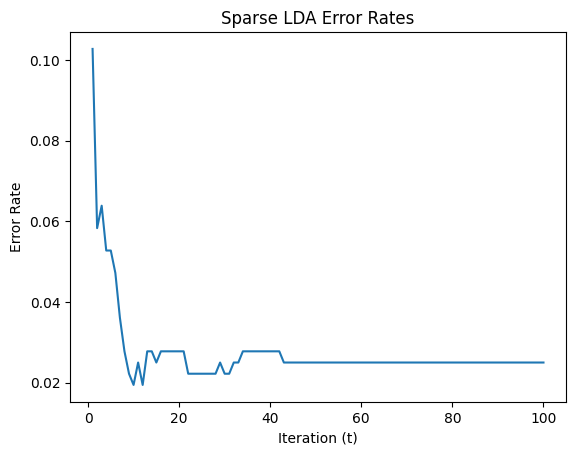

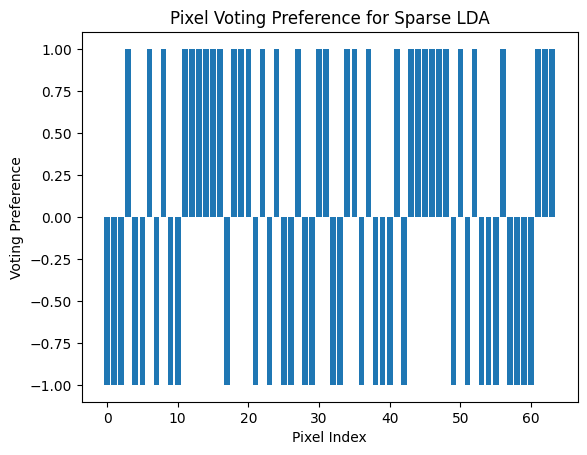

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def omp_regression(X, y, T):
    N, D = X.shape
    A = set()
    B = set(range(D))
    solutions = np.zeros((D, T))

    r = y
    for t in range(T):
        max_corr = -np.inf
        best_col = None

        for j in B:
            corr = np.abs(X[:, j].T @ r)
            if corr > max_corr:
                max_corr = corr
                best_col = j

        if best_col in B:  # Check if the best_col is still present in set B
            A.add(best_col)
            B.remove(best_col)  # Remove the best_col from set B

        X_active = X[:, list(A)]
        beta_t = np.linalg.lstsq(X_active, y, rcond=None)[0]
        solutions[list(A), t] = beta_t

        r = y - X_active @ beta_t

    return solutions


# Step 1: Load and preprocess the dataset
digits = load_digits()
X = digits.images.reshape(len(digits.images), -1)
y = np.where(digits.target == 3, 1, -1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 2: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Step 3: Perform sparse LDA using OMP
T = 100  # Set a sufficiently large T value

# Apply OMP regression
N, D = X_train.shape
A = set()
B = set(range(D))
solutions = np.zeros((D, T))

r = y_train
for t in range(T):
    max_corr = -np.inf
    best_col = None

    for j in B:
        corr = np.abs(X_train[:, j].T @ r)
        if corr > max_corr:
            max_corr = corr
            best_col = j

    if best_col in B:  # Check if the best_col is still present in set B
        A.add(best_col)
        B.remove(best_col)  # Remove the best_col from set B

    X_active = X_train[:, list(A)]
    beta_t = np.linalg.lstsq(X_active, y_train, rcond=None)[0]
    solutions[list(A), t] = beta_t

    r = y_train - X_active @ beta_t

# Step 4: Analyze the results
error_rates = []
for t in range(T):
    selected_features = np.nonzero(solutions[:, t])[0]
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    # Fit LDA model and make predictions
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_selected, y_train)
    y_pred = lda.predict(X_test_selected)

    # Calculate the classification error rate
    error_rate = 1 - accuracy_score(y_test, y_pred)
    error_rates.append(error_rate)

# Visualization: Error rates for each iteration
plt.plot(range(1, T+1), error_rates)
plt.xlabel('Iteration (t)')
plt.ylabel('Error Rate')
plt.title('Sparse LDA Error Rates')
plt.show()

# Visualization: Pixel order and voting preference
pixel_order = np.argsort(np.abs(solutions.sum(axis=1)))  # Order of pixels switched to active
voting_preference = np.sign(solutions.sum(axis=1))      # Voting preference for or against class '3'

plt.bar(range(len(pixel_order)), voting_preference[pixel_order])
plt.xlabel('Pixel Index')
plt.ylabel('Voting Preference')
plt.title('Pixel Voting Preference for Sparse LDA')
plt.show()
